# Classifier using LSTM layers

## 1. Importing Libraries

In [108]:
import torch

import pennylane as qml
import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 40

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [109]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories
    
    return categories[:n]

classes = get_categories_from_data(data_folder)
class_id = dict(zip(classes, range(len(classes))))


camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'camera': 0, 'cell phone': 1}

In [110]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes
    
    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)
    
    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]
    
    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0
    
    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]
    
    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)


# TODO: Limitar dataset
resized_cellphone_drawings = resized_cellphone_drawings[:5000]
resized_camera_drawings = resized_camera_drawings[:5000]

resized_camera_drawings.shape, resized_cellphone_drawings.shape

((5000, 95, 3), (5000, 95, 3))

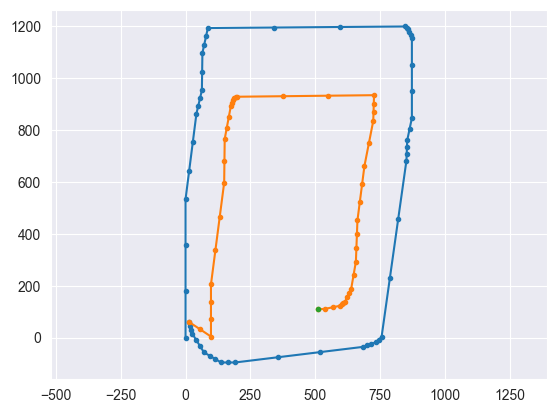

In [111]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()
    
    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()
    
draw_strokes(resized_cellphone_drawings[0])

In [112]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras and cellphones.
    
    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    test_size (float): The proportion of the dataset to include in the test split.
    
    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.zeros(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0])
    
    # Combine the drawings from both categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels], axis=0)
    
    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, test_size=0.2)

In [113]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 95, 3), (8000,), (2000, 95, 3), (2000,))

In [114]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.
    
    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
    
    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [115]:
print(len(train_loader))
print(len(test_loader))

200
50


## 3. Model Building

### 3.1. Quantum Layer

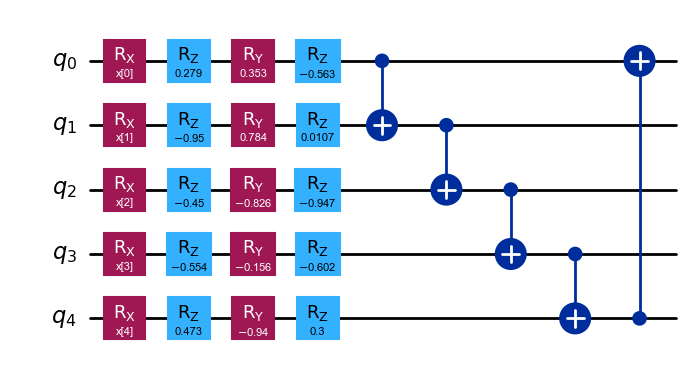

In [116]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def generate_random_params(num_params, lower_bound=-1, upper_bound=1, seed=None):
    if seed is not None:
        random.seed(seed)
    return [random.uniform(lower_bound, upper_bound) for _ in range(num_params)]

def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    # Generar valores aleatorios para los parámetros del ansatz con una semilla
    fixed_params = generate_random_params(3 * n, seed=42)
    parameter_values = {param: value for param, value in zip(ansatz.parameters, fixed_params)}
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz.assign_parameters(parameter_values), inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=None,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [117]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        
        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(
            create_qnn(n_qubits)[0],
        )
        
        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)
        
        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        
        # Pool layer
        x = self.pool3(x)
        
        # Flatten the output for dense layer
        x = torch.flatten(x, 1)
        
        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)
        
        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [118]:
checkpoint_filepath = 'models/quantum_lstm_qfixed/best_model_weights.pth'

In [119]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            
            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)
        
    # Imprimir parámetros entrenables
    #print("Entrenando parámetros en la época", epoch + 1)
    #for name, param in model.named_parameters():
    #    if param.requires_grad:
    #        print(f"{name}: {param.data}")

100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


Epoch 1, Accuracy: 0.4985, Loss: 0.6542123770713806, Validation Accuracy: 0.506, Validation Loss: 0.6227514743804932


100%|██████████| 200/200 [02:25<00:00,  1.37it/s]


Epoch 2, Accuracy: 0.4985, Loss: 0.600401970744133, Validation Accuracy: 0.506, Validation Loss: 0.6526961326599121


100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


Epoch 3, Accuracy: 0.4985, Loss: 0.5780562110245228, Validation Accuracy: 0.506, Validation Loss: 0.5495790243148804


100%|██████████| 200/200 [02:35<00:00,  1.28it/s]


Epoch 4, Accuracy: 0.4985, Loss: 0.5422443209588528, Validation Accuracy: 0.506, Validation Loss: 0.5239870548248291


100%|██████████| 200/200 [02:50<00:00,  1.18it/s]


Epoch 5, Accuracy: 0.4985, Loss: 0.5131372058391571, Validation Accuracy: 0.506, Validation Loss: 0.5014563202857971


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Epoch 6, Accuracy: 0.4985, Loss: 0.49143084183335306, Validation Accuracy: 0.506, Validation Loss: 0.47674092650413513


100%|██████████| 200/200 [02:47<00:00,  1.19it/s]


Epoch 7, Accuracy: 0.4985, Loss: 0.4770685414969921, Validation Accuracy: 0.506, Validation Loss: 0.469289094209671


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Epoch 8, Accuracy: 0.4985, Loss: 0.47292520314455033, Validation Accuracy: 0.506, Validation Loss: 0.45102864503860474


100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


Epoch 9, Accuracy: 0.4985, Loss: 0.47661315992474557, Validation Accuracy: 0.506, Validation Loss: 0.4853227138519287


100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Epoch 10, Accuracy: 0.4985, Loss: 0.4433635649085045, Validation Accuracy: 0.506, Validation Loss: 0.4274540841579437


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 11, Accuracy: 0.4985, Loss: 0.4264849524199963, Validation Accuracy: 0.506, Validation Loss: 0.41404402256011963


100%|██████████| 200/200 [02:49<00:00,  1.18it/s]


Epoch 12, Accuracy: 0.4985, Loss: 0.4188866436481476, Validation Accuracy: 0.506, Validation Loss: 0.4132431447505951


100%|██████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch 13, Accuracy: 0.4985, Loss: 0.4136237046122551, Validation Accuracy: 0.506, Validation Loss: 0.40185344219207764


100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


Epoch 14, Accuracy: 0.4985, Loss: 0.40346618443727494, Validation Accuracy: 0.506, Validation Loss: 0.3935414254665375


100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


Epoch 15, Accuracy: 0.4985, Loss: 0.40009263783693316, Validation Accuracy: 0.506, Validation Loss: 0.38784900307655334


100%|██████████| 200/200 [02:49<00:00,  1.18it/s]


Epoch 16, Accuracy: 0.4985, Loss: 0.3965368553996086, Validation Accuracy: 0.506, Validation Loss: 0.38991019129753113


100%|██████████| 200/200 [02:49<00:00,  1.18it/s]


Epoch 17, Accuracy: 0.4985, Loss: 0.39564840666949747, Validation Accuracy: 0.506, Validation Loss: 0.3861018121242523


100%|██████████| 200/200 [02:45<00:00,  1.21it/s]


Epoch 18, Accuracy: 0.4985, Loss: 0.390856159478426, Validation Accuracy: 0.506, Validation Loss: 0.3824816048145294


100%|██████████| 200/200 [02:51<00:00,  1.17it/s]


Epoch 19, Accuracy: 0.4985, Loss: 0.3855479845404625, Validation Accuracy: 0.506, Validation Loss: 0.39655426144599915


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


Epoch 20, Accuracy: 0.4985, Loss: 0.3862034139037132, Validation Accuracy: 0.506, Validation Loss: 0.3799145519733429


100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


Epoch 21, Accuracy: 0.4985, Loss: 0.38346785202622413, Validation Accuracy: 0.506, Validation Loss: 0.37829485535621643


100%|██████████| 200/200 [02:51<00:00,  1.17it/s]


Epoch 22, Accuracy: 0.4985, Loss: 0.38097843050956726, Validation Accuracy: 0.506, Validation Loss: 0.3952205777168274


100%|██████████| 200/200 [02:47<00:00,  1.19it/s]


Epoch 23, Accuracy: 0.4985, Loss: 0.3807724680006504, Validation Accuracy: 0.506, Validation Loss: 0.3842332363128662


100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


Epoch 24, Accuracy: 0.4985, Loss: 0.380466595441103, Validation Accuracy: 0.506, Validation Loss: 0.37137043476104736


100%|██████████| 200/200 [02:59<00:00,  1.12it/s]


Epoch 25, Accuracy: 0.4985, Loss: 0.37894668042659757, Validation Accuracy: 0.506, Validation Loss: 0.3747783899307251


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch 26, Accuracy: 0.4985, Loss: 0.37698327608406546, Validation Accuracy: 0.506, Validation Loss: 0.37040233612060547


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 27, Accuracy: 0.4985, Loss: 0.3742275759577751, Validation Accuracy: 0.506, Validation Loss: 0.3680417239665985


100%|██████████| 200/200 [02:57<00:00,  1.12it/s]


Epoch 28, Accuracy: 0.4985, Loss: 0.3660091395676136, Validation Accuracy: 0.506, Validation Loss: 0.3679371774196625


100%|██████████| 200/200 [03:00<00:00,  1.11it/s]


Epoch 29, Accuracy: 0.4985, Loss: 0.36643564492464065, Validation Accuracy: 0.506, Validation Loss: 0.3651023805141449


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch 30, Accuracy: 0.4985, Loss: 0.36467294685542584, Validation Accuracy: 0.506, Validation Loss: 0.38004833459854126


100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch 31, Accuracy: 0.4985, Loss: 0.3662664782255888, Validation Accuracy: 0.506, Validation Loss: 0.3690449893474579


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch 32, Accuracy: 0.4985, Loss: 0.3638943898677826, Validation Accuracy: 0.506, Validation Loss: 0.36566779017448425


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 33, Accuracy: 0.4985, Loss: 0.360095839202404, Validation Accuracy: 0.506, Validation Loss: 0.3743469715118408


100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch 34, Accuracy: 0.4985, Loss: 0.36092339038848875, Validation Accuracy: 0.506, Validation Loss: 0.36674919724464417


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch 35, Accuracy: 0.4985, Loss: 0.36334107428789136, Validation Accuracy: 0.506, Validation Loss: 0.37506699562072754


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 36, Accuracy: 0.4985, Loss: 0.3632175309956074, Validation Accuracy: 0.506, Validation Loss: 0.3680887520313263


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch 37, Accuracy: 0.4985, Loss: 0.3590781321376562, Validation Accuracy: 0.506, Validation Loss: 0.3694797158241272


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 38, Accuracy: 0.4985, Loss: 0.36052069410681725, Validation Accuracy: 0.506, Validation Loss: 0.3747463524341583


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 39, Accuracy: 0.4985, Loss: 0.3623311427235603, Validation Accuracy: 0.506, Validation Loss: 0.3745756149291992


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 40, Accuracy: 0.4985, Loss: 0.36092254787683486, Validation Accuracy: 0.506, Validation Loss: 0.3804716169834137


100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


Epoch 41, Accuracy: 0.4985, Loss: 0.36479043163359165, Validation Accuracy: 0.506, Validation Loss: 0.37373653054237366


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 42, Accuracy: 0.4985, Loss: 0.35871267803013324, Validation Accuracy: 0.506, Validation Loss: 0.3814740777015686


100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch 43, Accuracy: 0.4985, Loss: 0.3620103345066309, Validation Accuracy: 0.506, Validation Loss: 0.36755573749542236


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 44, Accuracy: 0.4985, Loss: 0.35936840683221816, Validation Accuracy: 0.506, Validation Loss: 0.36020129919052124


100%|██████████| 200/200 [03:04<00:00,  1.09it/s]


Epoch 45, Accuracy: 0.4985, Loss: 0.3579884646832943, Validation Accuracy: 0.506, Validation Loss: 0.366155207157135


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 46, Accuracy: 0.4985, Loss: 0.3676748014241457, Validation Accuracy: 0.506, Validation Loss: 0.37434548139572144


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 47, Accuracy: 0.4985, Loss: 0.36121260181069376, Validation Accuracy: 0.506, Validation Loss: 0.3660033941268921


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 48, Accuracy: 0.4985, Loss: 0.3588388529419899, Validation Accuracy: 0.506, Validation Loss: 0.384926974773407


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch 49, Accuracy: 0.4985, Loss: 0.3565177195519209, Validation Accuracy: 0.506, Validation Loss: 0.3750201463699341


100%|██████████| 200/200 [03:07<00:00,  1.07it/s]


Epoch 50, Accuracy: 0.4985, Loss: 0.3590150573849678, Validation Accuracy: 0.506, Validation Loss: 0.36944258213043213


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Epoch 51, Accuracy: 0.4985, Loss: 0.3561396186798811, Validation Accuracy: 0.506, Validation Loss: 0.37976714968681335


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch 52, Accuracy: 0.4985, Loss: 0.36291773796081545, Validation Accuracy: 0.506, Validation Loss: 0.36741015315055847


100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


Epoch 53, Accuracy: 0.4985, Loss: 0.3559928747266531, Validation Accuracy: 0.506, Validation Loss: 0.3669571578502655


100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Epoch 54, Accuracy: 0.4985, Loss: 0.36793599553406237, Validation Accuracy: 0.506, Validation Loss: 0.3768223524093628


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 55, Accuracy: 0.4985, Loss: 0.36445446565747264, Validation Accuracy: 0.506, Validation Loss: 0.3719680905342102


100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch 56, Accuracy: 0.4985, Loss: 0.3569235273450613, Validation Accuracy: 0.506, Validation Loss: 0.38004013895988464


100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch 57, Accuracy: 0.4985, Loss: 0.35772735469043254, Validation Accuracy: 0.506, Validation Loss: 0.36410248279571533


100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch 58, Accuracy: 0.4985, Loss: 0.3584091763943434, Validation Accuracy: 0.506, Validation Loss: 0.3663369119167328


100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Epoch 59, Accuracy: 0.4985, Loss: 0.356369191929698, Validation Accuracy: 0.506, Validation Loss: 0.3673675060272217


100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch 60, Accuracy: 0.4985, Loss: 0.35529740922152997, Validation Accuracy: 0.506, Validation Loss: 0.3692677319049835


100%|██████████| 200/200 [03:26<00:00,  1.03s/it]


Epoch 61, Accuracy: 0.4985, Loss: 0.3572831227630377, Validation Accuracy: 0.506, Validation Loss: 0.3625241816043854


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 62, Accuracy: 0.4985, Loss: 0.35461711190640927, Validation Accuracy: 0.506, Validation Loss: 0.38329991698265076


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 63, Accuracy: 0.4985, Loss: 0.35710760347545145, Validation Accuracy: 0.506, Validation Loss: 0.37407249212265015


100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch 64, Accuracy: 0.4985, Loss: 0.3554977786540985, Validation Accuracy: 0.506, Validation Loss: 0.36797431111335754


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch 65, Accuracy: 0.4985, Loss: 0.3546868743747473, Validation Accuracy: 0.506, Validation Loss: 0.3741339445114136


100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Epoch 66, Accuracy: 0.4985, Loss: 0.3547897103428841, Validation Accuracy: 0.506, Validation Loss: 0.3619888722896576


100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Epoch 67, Accuracy: 0.4985, Loss: 0.3532114323228598, Validation Accuracy: 0.506, Validation Loss: 0.3732561469078064


100%|██████████| 200/200 [03:38<00:00,  1.09s/it]


Epoch 68, Accuracy: 0.4985, Loss: 0.35451265424489975, Validation Accuracy: 0.506, Validation Loss: 0.3783479928970337


100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


Epoch 69, Accuracy: 0.4985, Loss: 0.35353930830955504, Validation Accuracy: 0.506, Validation Loss: 0.3642156720161438


100%|██████████| 200/200 [03:48<00:00,  1.14s/it]


Epoch 70, Accuracy: 0.4985, Loss: 0.3584192095696926, Validation Accuracy: 0.506, Validation Loss: 0.3665548264980316


100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


Epoch 71, Accuracy: 0.4985, Loss: 0.3547957737743854, Validation Accuracy: 0.506, Validation Loss: 0.3669447600841522


100%|██████████| 200/200 [03:34<00:00,  1.07s/it]


Epoch 72, Accuracy: 0.4985, Loss: 0.35540824353694916, Validation Accuracy: 0.506, Validation Loss: 0.36239051818847656


100%|██████████| 200/200 [03:36<00:00,  1.08s/it]


Epoch 73, Accuracy: 0.4985, Loss: 0.3557653380930424, Validation Accuracy: 0.506, Validation Loss: 0.3757944405078888


100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


Epoch 74, Accuracy: 0.4985, Loss: 0.3562658006697893, Validation Accuracy: 0.506, Validation Loss: 0.3703128397464752


100%|██████████| 200/200 [03:29<00:00,  1.05s/it]


Epoch 75, Accuracy: 0.4985, Loss: 0.355959312915802, Validation Accuracy: 0.506, Validation Loss: 0.37534481287002563


100%|██████████| 200/200 [03:34<00:00,  1.07s/it]


Epoch 76, Accuracy: 0.4985, Loss: 0.3547396659851074, Validation Accuracy: 0.506, Validation Loss: 0.36290428042411804


100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


Epoch 77, Accuracy: 0.4985, Loss: 0.35541294887661934, Validation Accuracy: 0.506, Validation Loss: 0.3781200051307678


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 78, Accuracy: 0.4985, Loss: 0.3559920147061348, Validation Accuracy: 0.506, Validation Loss: 0.3703550100326538


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 79, Accuracy: 0.4985, Loss: 0.352717459872365, Validation Accuracy: 0.506, Validation Loss: 0.3818172812461853


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 80, Accuracy: 0.4985, Loss: 0.35496930085122586, Validation Accuracy: 0.506, Validation Loss: 0.3736463487148285


100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch 81, Accuracy: 0.4985, Loss: 0.35782468907535075, Validation Accuracy: 0.506, Validation Loss: 0.388141393661499


100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch 82, Accuracy: 0.4985, Loss: 0.35366638235747816, Validation Accuracy: 0.506, Validation Loss: 0.36734268069267273


100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch 83, Accuracy: 0.4985, Loss: 0.3538345452398062, Validation Accuracy: 0.506, Validation Loss: 0.37824055552482605


100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch 84, Accuracy: 0.4985, Loss: 0.3547590500861406, Validation Accuracy: 0.506, Validation Loss: 0.37796059250831604


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 85, Accuracy: 0.4985, Loss: 0.35970003813505175, Validation Accuracy: 0.506, Validation Loss: 0.36965930461883545


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 86, Accuracy: 0.4985, Loss: 0.3534826262295246, Validation Accuracy: 0.506, Validation Loss: 0.37054842710494995


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch 87, Accuracy: 0.4985, Loss: 0.3580035400390625, Validation Accuracy: 0.506, Validation Loss: 0.3932873606681824


100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch 88, Accuracy: 0.4985, Loss: 0.35663188457489015, Validation Accuracy: 0.506, Validation Loss: 0.372323215007782


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 89, Accuracy: 0.4985, Loss: 0.35346809767186643, Validation Accuracy: 0.506, Validation Loss: 0.38878196477890015


100%|██████████| 200/200 [03:17<00:00,  1.02it/s]


Epoch 90, Accuracy: 0.4985, Loss: 0.3547819121181965, Validation Accuracy: 0.506, Validation Loss: 0.37212294340133667


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 91, Accuracy: 0.4985, Loss: 0.35397080704569817, Validation Accuracy: 0.506, Validation Loss: 0.36659950017929077


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 92, Accuracy: 0.4985, Loss: 0.35519587457180024, Validation Accuracy: 0.506, Validation Loss: 0.37414395809173584


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 93, Accuracy: 0.4985, Loss: 0.3528243841975927, Validation Accuracy: 0.506, Validation Loss: 0.36800849437713623


100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch 94, Accuracy: 0.4985, Loss: 0.35170608907938006, Validation Accuracy: 0.506, Validation Loss: 0.37596404552459717


100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch 95, Accuracy: 0.4985, Loss: 0.3533331627398729, Validation Accuracy: 0.506, Validation Loss: 0.3747144937515259


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch 96, Accuracy: 0.4985, Loss: 0.3538355945050716, Validation Accuracy: 0.506, Validation Loss: 0.3709321618080139


100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch 97, Accuracy: 0.4985, Loss: 0.35610149867832663, Validation Accuracy: 0.506, Validation Loss: 0.36756759881973267


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 98, Accuracy: 0.4985, Loss: 0.35467755995690825, Validation Accuracy: 0.506, Validation Loss: 0.37255755066871643


100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch 99, Accuracy: 0.4985, Loss: 0.35248965963721274, Validation Accuracy: 0.506, Validation Loss: 0.3718825876712799


100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch 100, Accuracy: 0.4985, Loss: 0.35381568878889086, Validation Accuracy: 0.506, Validation Loss: 0.37133458256721497


## 5. Model Evaluation

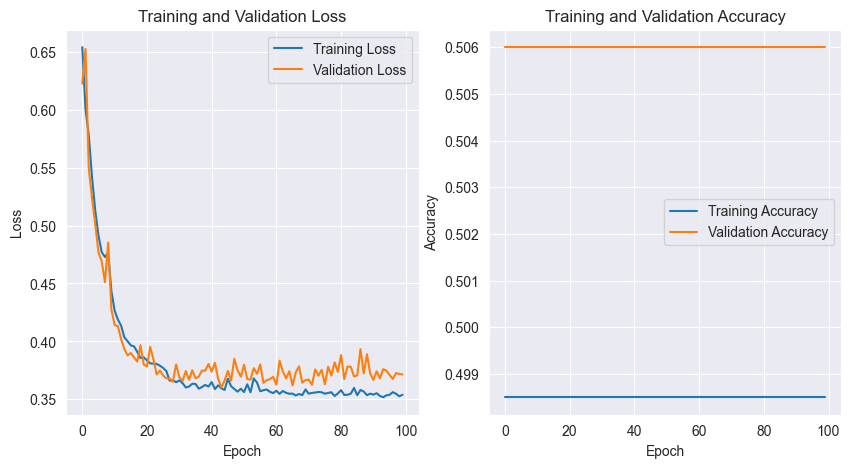

In [120]:
def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [121]:
nn = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)
y_pred = nn.predict(X_test)

In [122]:
pred = np.argmax(y_pred.data, axis=1)

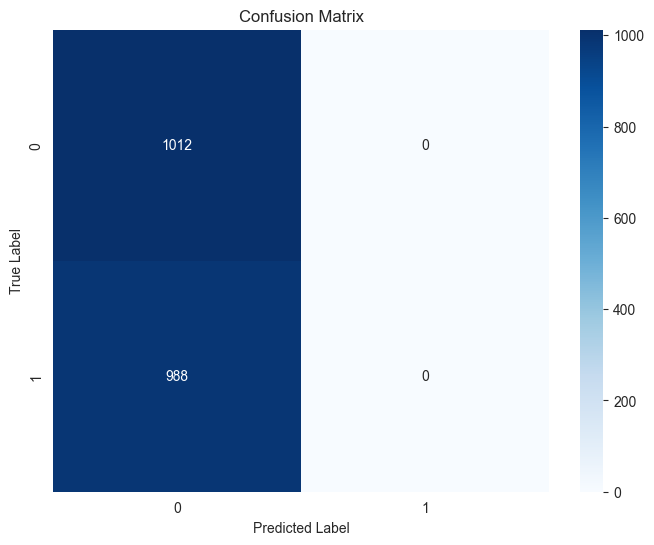

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test.astype(np.int8), np.argmax(y_pred, axis=1))